In [ ]:
# install packages required for boosting and contrastive learning
!pip install git+https://github.com/clabrugere/pytorch-scarf.git
!pip install aif360
!pip install tqdm
!pip install pandas
!pip install scikit-learn
!pip install xgboost
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
# checking if we have gpu
import torch

print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')

def check_gpu():
    if torch.cuda.is_available():
        print("CUDA is available! Running on GPU...")
        device = torch.device("cuda")
        print(f"Device Name: {torch.cuda.get_device_name()}")
    else:
        print("CUDA is not available. Running on CPU...")
        device = torch.device("cpu")
    return device

device = check_gpu()

PyTorch version: 2.2.0
**********
CUDNN version: None
Available GPU devices: 0
CUDA is not available. Running on CPU...


In [2]:
# Imports
from scarf.loss import NTXent
from scarf.model import SCARF
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from tqdm import tqdm
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from aif360.sklearn.datasets import fetch_adult, fetch_compas
from sklearn.preprocessing import MinMaxScaler

In [3]:
# creating the dataset class for the dataloader
class SCARFDataset(Dataset):
    def __init__(self, data, target, columns=None):
        self.data = np.array(data)
        self.target = np.array(target)
        self.columns = columns

    # we need these properties to corrupt features of data points - this is how SCARF works

    @property
    def features_low(self):
        return self.data.min(axis=0)

    @property
    def features_high(self):
        return self.data.max(axis=0)

    @property
    def shape(self):
        return self.data.shape

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

In [4]:
# Hyperparameters & Helper Functions
def dataset_embeddings(model, loader, device):
    embeddings = []

    for x in tqdm(loader):
        x = x.to(device)
        # getting embeddings of the data for later
        embeddings.append(model.get_embeddings(x))

    embeddings = torch.cat(embeddings).cpu().numpy()

    return embeddings


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# hyperparameters
batch_size = 128
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1234
fix_seed(seed)

In [5]:
dataset = "compas"  # Either compas or adult

# preprocessing the datasets - ensuring that we are not multindex, we don't have constant columns, huge outliers etc.

if dataset == "adult":
    X, y, _ = fetch_adult()
    X.index = y.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
    y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)
    X = pd.get_dummies(X, prefix_sep="__", drop_first=True)
    X = X.reset_index()
    y = y.reset_index()
    X.fillna(0, inplace=True)
    y.drop(columns=["race", "sex"], inplace=True)
    y = y["annual-income"].squeeze()
    train_data, test_data, train_target, test_target = train_test_split(
        X, y, train_size=16281, shuffle=False)
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)
    protected = ["race", "sex"]

elif dataset == "compas":
    cols = ["sex", "race", "age_cat", "priors_count", "c_charge_degree"]
    X, y = fetch_compas(usecols=cols, binary_race=True)

    # Quantize priors count between 0, 1-3, and >3
    X["priors_count"] = pd.cut(
        X["priors_count"], [-1, 0, 3, 100], labels=[0, 1, 2]
    )
    le = LabelEncoder()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    y = y.replace({"Recidivated": 1, "Survived": 0})
    X = X.apply(lambda x: pd.factorize(x)[0])
    train_data, test_data, train_target, test_target = train_test_split(
        X, y, test_size=3694, shuffle=True, random_state=0
    )
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)
    protected = ["sex", "race"]

else:
    print("Error! Dataset not found.")

protected_indices = [0, 1]
train_ds = SCARFDataset(train_data.to_numpy().astype(float), train_target.to_numpy(), columns=train_data.columns)
test_ds = SCARFDataset(test_data.to_numpy().astype(float), test_data.to_numpy(), columns=test_data.columns)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")

Train set: (1584, 5)
Test set: (3694, 5)


/var/folders/_j/7xf6n_ts231_sz96nsh2r8rm0000gn/T/ipykernel_5832/2902550724.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"Recidivated": 1, "Survived": 0})
/var/folders/_j/7xf6n_ts231_sz96nsh2r8rm0000gn/T/ipykernel_5832/2902550724.py:33: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y = y.replace({"Recidivated": 1, "Survived": 0})


In [6]:
# Model
model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=8,
    num_hidden_encoder=3,
    dim_hidden_head=24,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = NTXent()

In [7]:

loss_history = []

# Training for accuracy
def train_for_accuracy():
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for x in train_loader:
            x = x.to(device)
            emb_anchor, emb_positive = model(x) # positive pairs, should be mapped closer

            loss = criterion(emb_anchor, emb_positive) # negative pairs are implied, they are the other data points in the dataset
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()

        loss_history.append(epoch_loss)
        if epoch % 10 == 0:
            print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")
train_for_accuracy()

epoch 10/1000 - loss: 67.0231
epoch 20/1000 - loss: 66.5543
epoch 30/1000 - loss: 66.1956
epoch 40/1000 - loss: 66.3172
epoch 50/1000 - loss: 66.0390
epoch 60/1000 - loss: 66.1130
epoch 70/1000 - loss: 66.2122
epoch 80/1000 - loss: 66.1620
epoch 90/1000 - loss: 65.9684
epoch 100/1000 - loss: 65.9578
epoch 110/1000 - loss: 65.8960
epoch 120/1000 - loss: 66.0483
epoch 130/1000 - loss: 65.6656
epoch 140/1000 - loss: 66.0209
epoch 150/1000 - loss: 65.9075
epoch 160/1000 - loss: 65.9557
epoch 170/1000 - loss: 65.8038
epoch 180/1000 - loss: 65.7260
epoch 190/1000 - loss: 65.6743
epoch 200/1000 - loss: 65.9313
epoch 210/1000 - loss: 65.7394
epoch 220/1000 - loss: 65.7972
epoch 230/1000 - loss: 65.6670
epoch 240/1000 - loss: 65.9820
epoch 250/1000 - loss: 65.6930
epoch 260/1000 - loss: 65.7072
epoch 270/1000 - loss: 65.5892
epoch 280/1000 - loss: 65.4975
epoch 290/1000 - loss: 65.6315
epoch 300/1000 - loss: 65.7594
epoch 310/1000 - loss: 65.4412
epoch 320/1000 - loss: 65.4716
epoch 330/1000 - 

In [8]:
loss_history_fair = []

# Train for fairness
def train_for_fairness():
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for x in train_loader:
            x = x.to(device)
            x_copy = x.clone()
            
            # for each data point, we create a synthetic opposite where we flip the protected attributes
            for row_idx in range(x_copy.size(0)):
                for idx in protected_indices:
                    x_copy[row_idx, idx] = 1 - x_copy[row_idx, idx]
            emb_x, _ = model(x)
            emb_x_copy, _ = model(x_copy)
            loss = criterion(emb_x, emb_x_copy) # emb_x and its synthetic pair are positive pairs with flipped protected attributes
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()

        loss_history_fair.append(epoch_loss)

        if epoch % 10 == 0:
            print(f"epoch {epoch}/{epochs} - loss: {loss_history_fair[-1]:.4f}")
train_for_fairness()

epoch 10/1000 - loss: 61.6546
epoch 20/1000 - loss: 61.4922
epoch 30/1000 - loss: 61.4710
epoch 40/1000 - loss: 61.3108
epoch 50/1000 - loss: 61.2999
epoch 60/1000 - loss: 61.2625
epoch 70/1000 - loss: 60.9573
epoch 80/1000 - loss: 60.8916
epoch 90/1000 - loss: 60.7884
epoch 100/1000 - loss: 60.7348
epoch 110/1000 - loss: 60.6032
epoch 120/1000 - loss: 60.5619
epoch 130/1000 - loss: 60.4329
epoch 140/1000 - loss: 60.5529
epoch 150/1000 - loss: 60.5523
epoch 160/1000 - loss: 60.5414
epoch 170/1000 - loss: 60.3801
epoch 180/1000 - loss: 60.6217
epoch 190/1000 - loss: 60.6377
epoch 200/1000 - loss: 60.4636
epoch 210/1000 - loss: 60.3762
epoch 220/1000 - loss: 60.4473
epoch 230/1000 - loss: 60.4259
epoch 240/1000 - loss: 60.2383
epoch 250/1000 - loss: 60.3791
epoch 260/1000 - loss: 60.4376
epoch 270/1000 - loss: 60.2996
epoch 280/1000 - loss: 60.4208
epoch 290/1000 - loss: 60.2308
epoch 300/1000 - loss: 60.2741
epoch 310/1000 - loss: 60.3195
epoch 320/1000 - loss: 60.2902
epoch 330/1000 - 

In [9]:
# Save model weights
torch.save(model.state_dict(), "contrastive_learner_compas.pth")

Text(0, 0.5, 'loss')

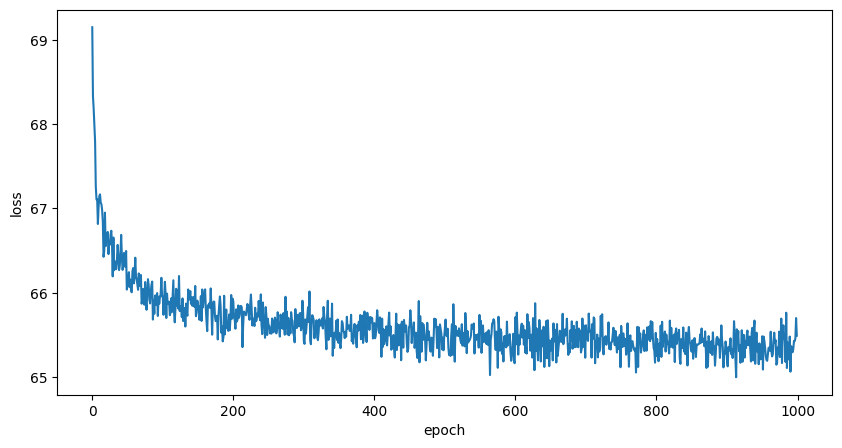

In [10]:
# Plot loss history of regular training

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

Text(0, 0.5, 'loss')

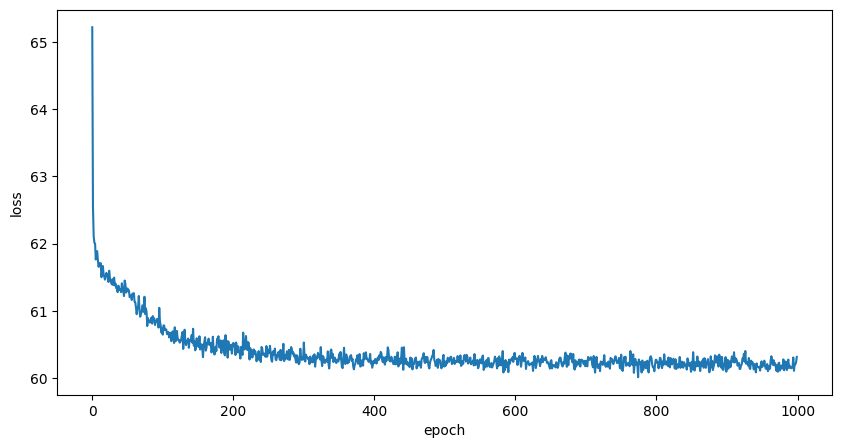

In [11]:
# Plot loss history of fairness training

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history_fair)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [12]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|██████████| 29/29 [00:00<00:00, 1350.28it/s]

(1584, 8)
(3694, 8)


              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1957
           1       0.57      0.51      0.54      1737

    accuracy                           0.59      3694
   macro avg       0.58      0.58      0.58      3694
weighted avg       0.58      0.59      0.58      3694



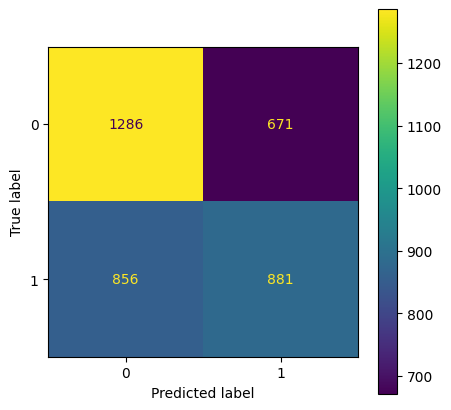

In [13]:
clf_vanilla = LogisticRegression()
# vanilla dataset: train the classifier on the original data
clf_vanilla.fit(train_data, train_target)
vanilla_predictions = clf_vanilla.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1957
           1       0.54      0.54      0.54      1737

    accuracy                           0.57      3694
   macro avg       0.57      0.57      0.57      3694
weighted avg       0.57      0.57      0.57      3694



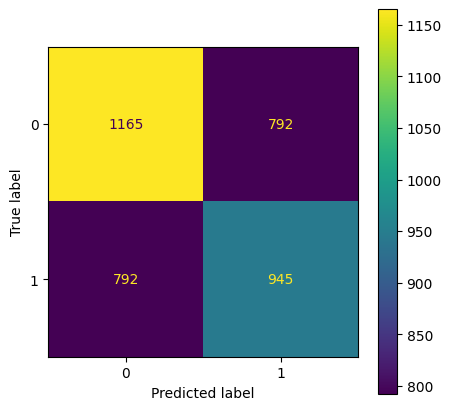

In [14]:
# embeddings dataset: train the classifier on the embeddings
clf = LogisticRegression()
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

In [15]:
#Visualizing the embeddings with T-sne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings[:2000])
positive = train_target[:2000] == 1

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

In [ ]:
# Generate synthetic Data for fairness testing
def generate_synthetic_data(df):
    synthetic_data = {}
    for column in df.columns:
        if df[column].dtype in ["int64", "float64", "int8"]:
            # we make sure that the synthetic data is within the bounds of the original training data
            min_value = df[column].min()
            max_value = df[column].max()
            synthetic_data[column] = np.random.uniform(
                min_value, max_value, size=len(df)
            )
        elif df[column].dtype == "object":
            # choose a random string that has already been seen
            unique_values = df[column].unique()
            synthetic_data[column] = np.random.choice(unique_values, size=len(df))
        elif df[column].dtype == "bool":
            synthetic_data[column] = np.random.choice([True, False], size=len(df))
        else:
            synthetic_data[column] = [np.nan] * len(df)

    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
    return synthetic_df

fairness_test_df = generate_synthetic_data(train_data)

# the idea is that we create a synthetic dataset from which we generate flipped protected attribute pairs
fairness_test_ds = SCARFDataset(
    fairness_test_df.to_numpy().astype(float),
    train_target.to_numpy(),
    columns=fairness_test_df.columns,
)  # The other 2 parameters don't really matter

fairness_test_loader = DataLoader(
    fairness_test_ds, batch_size=batch_size, shuffle=False
)


In [ ]:
# Testing Fairness
fairness_vanilla = []
fairness_embed = []

model.eval()

for _, x in fairness_test_df.iterrows():
    x_copy = x.to_frame().T
    
    # flip the protected attributes
    for attribute in protected:
        x_copy[attribute] = 1 - x_copy[attribute]
        
    vanilla_x = clf_vanilla.predict(x.values.reshape(1, -1))
    vanilla_x_copy = clf_vanilla.predict(x_copy.values.reshape(1, -1))
    # see if the model classifies them both as the same
    fairness_vanilla.append(1 if vanilla_x == vanilla_x_copy else 0)

for x in fairness_test_loader:
    x = x.to(device)
    x_copy = x.clone()
    for i in protected_indices:
        x_copy[i] = 1 - x[i]

    embed_x = model.get_embeddings(x).cpu().numpy()
    embed_x_copy = model.get_embeddings(x_copy).cpu().numpy()
    cl_x, cl_x_copy = clf.predict(embed_x), clf.predict(embed_x_copy)
    for (embed_pred_x, embed_pred_x_copy) in zip(cl_x, cl_x_copy):
        fairness_embed.append(1 if embed_pred_x == embed_pred_x_copy else 0)

vanilla_fair_score = np.mean(np.array(fairness_vanilla))
embed_fair_score = np.mean(np.array(fairness_embed))

In [ ]:
print(vanilla_fair_score)
print(embed_fair_score)

0.9046717171717171
0.9936868686868687


              precision    recall  f1-score   support

           0       0.60      0.72      0.66      1957
           1       0.59      0.46      0.52      1737

    accuracy                           0.60      3694
   macro avg       0.60      0.59      0.59      3694
weighted avg       0.60      0.60      0.59      3694

0.9842171717171717


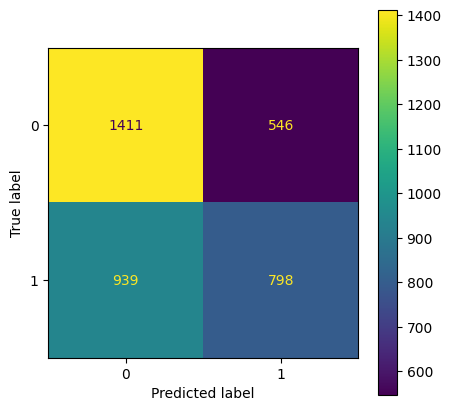

In [ ]:
# Booster 
import xgboost as xgb
from sklearn.metrics import roc_auc_score

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 1,
    "min_child_weight": 1,
    "verbosity": 0,
}

# generic xgb booster trained on the embeddings
dtrain = xgb.DMatrix(train_embeddings, label=train_target)
dtest = xgb.DMatrix(test_embeddings, label=test_target)

num_rounds = 100
booster_model = xgb.train(params, dtrain, num_rounds)

y_pred = booster_model.predict(dtest)
y_pred_binary = (y_pred >=0.5).astype(int)
print(classification_report(test_target, y_pred_binary))
cm = confusion_matrix(test_target, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# same fairness testing code
fairness_scores = []
for x in fairness_test_loader:
    x = x.to(device)
    x_copy = x.clone()
    for i in protected_indices:
        x_copy[i] = 1 - x[i]

    embed_x = model.get_embeddings(x).cpu().numpy()
    embed_x_copy = model.get_embeddings(x_copy).cpu().numpy()
    dembed_x = xgb.DMatrix(embed_x)
    dembed_x_copy = xgb.DMatrix(embed_x_copy)
    cl_x, cl_x_copy = booster_model.predict(dembed_x), booster_model.predict(
        dembed_x_copy
    )
    fairness_scores.extend((cl_x == cl_x_copy).astype(int))

fairness_booster_score = np.mean(np.array(fairness_scores))
print(fairness_booster_score)

#Extra metrics:
auc_score = roc_auc_score(test_target, y_pred)

print(f"AUC Score: {auc_score:.4f}")